# Muse EEG Analysis

For use with the Muse headband + Mind Monitor app.

Mind Monitor settings:
Recording Format = CSV
Recording Interval = Constant

Record 5 mins of eyes closed, without active meditation.

copy the CSV file from dropbox, to this notebooks files.

Cell 1
point the data_file to the csv path

Cell 2
Preprocesses the data and creates a graph overview

Cell 3
Extracts various potential bio markers for tracking, such as DAR ratio for adult ADHD, and average PAF for general brain health



In [1]:
# OPTION 1 - Grab the most recent data file from the raw_data directory

import os
import glob

data_file = max(glob.glob('./raw_data/*.csv'), key=os.path.getctime)

# OR...

# OPTION 2 - Specify the path to your EEG data file

# data_file = 'insert/path/to/your/data_file.csv'

# show path on success
data_file

'./raw_data/mindMonitor_2024-04-09--11-33-04.csv'

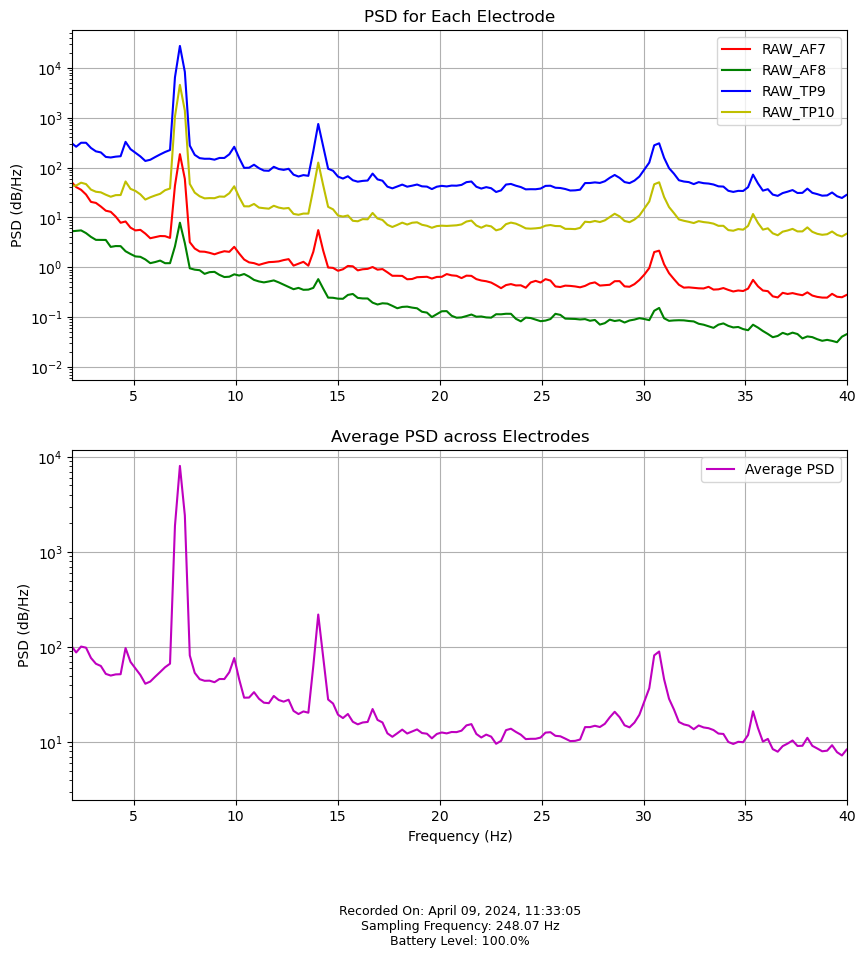

In [2]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import welch
import matplotlib.pyplot as plt
import csv

# Assuming electrode_columns and preprocess_eeg_data function are defined as in your original script
electrode_columns = ['RAW_AF7', 'RAW_AF8', 'RAW_TP9', 'RAW_TP10']

# Initialize an array to store PSDs for averaging
all_psds = []   

def preprocess_eeg_data(data_file):
    # Load EEG data
    df = pd.read_csv(data_file)
    
    # Convert 'TimeStamp' and 'Battery' columns
    df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
    first_timestamp = df['TimeStamp'].iloc[0]  # taking first timestamp
    battery_level = df['Battery'].iloc[-1]  # taking last battery level

    # List of electrode columns to analyze
    electrode_columns = ['RAW_AF7', 'RAW_AF8', 'RAW_TP9', 'RAW_TP10']

    # Convert 'TimeStamp' column to datetime objects
    df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])

    # Calculate the duration by summing the differences between consecutive timestamps
    durations = df['TimeStamp'].diff().dropna()
    duration_seconds = durations.sum().total_seconds()

    # Create a new DataFrame with interpolated timestamps
    interpolated_df = pd.DataFrame({'TimeStamp': pd.date_range(
        start=df['TimeStamp'].iloc[0], end=df['TimeStamp'].iloc[-1], periods=len(df))})

    # Calculate the sampling frequency using the interpolated timestamps
    num_samples = len(interpolated_df)
    sampling_frequency = num_samples / duration_seconds

    preprocessed_data = {}
    # Loop through each electrode column
    for column in electrode_columns:
        eeg_data = df[column].values

        # Handle missing data points
        missing_mask = np.isnan(eeg_data)
        eeg_data[missing_mask] = np.interp(np.flatnonzero(
            missing_mask), np.flatnonzero(~missing_mask), eeg_data[~missing_mask])

        # Interpolate the EEG data to match the interpolated timestamps
        interp_func = interp1d(df['TimeStamp'].astype(
            np.int64), eeg_data, kind='linear', fill_value='extrapolate')
        interpolated_eeg_data = interp_func(
            interpolated_df['TimeStamp'].astype(np.int64))

        preprocessed_data[column] = interpolated_eeg_data

    return preprocessed_data, sampling_frequency, first_timestamp, battery_level

# Your preprocessing and data loading steps remain unchanged
preprocessed_data, sampling_frequency, first_timestamp, battery_level = preprocess_eeg_data(data_file)

# Start modifications from here

# Information to be included in the plot
info_text = (
    f"Recorded On: {first_timestamp.strftime('%B %d, %Y, %H:%M:%S')}\n"
    f"Sampling Frequency: {sampling_frequency:.2f} Hz\n"
    f"Battery Level: {battery_level}%"
)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))  # Two subplots: one for combined electrodes, one for average

# Dictionary to store colors for each electrode for consistency
colors = {'RAW_AF7': 'r', 'RAW_AF8': 'g', 'RAW_TP9': 'b', 'RAW_TP10': 'y'}

# Plot each electrode's PSD on the same subplot
for column in electrode_columns:
    eeg_data = preprocessed_data[column]
    frequencies, psd = welch(eeg_data, fs=sampling_frequency, nperseg=1024)
    all_psds.append(psd)
    axs[0].semilogy(frequencies, psd, label=f'{column}', color=colors[column])
axs[0].set_ylabel('PSD (dB/Hz)')
axs[0].set_title('PSD for Each Electrode')
axs[0].grid(True)
axs[0].set_xlim([2, 40])
axs[0].legend()

# Plot the average PSD on the second subplot
average_psd = np.mean(all_psds, axis=0)
axs[1].semilogy(frequencies, average_psd, label='Average PSD', color='m')
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('PSD (dB/Hz)')
axs[1].set_title('Average PSD across Electrodes')
axs[1].grid(True)
axs[1].set_xlim([2, 40])
axs[1].legend()

# Add information text to the last subplot
axs[1].text(0.5, -0.3, info_text, transform=axs[1].transAxes, fontsize=9, ha="center", va="top")

png_file = data_file.replace('.csv', '.png')
png_path = png_file.replace('raw_data', 'outputs/images')
# Save the figure
fig.savefig(png_path, bbox_inches="tight")


In [3]:
# Print bio markers as text, and append to the ongoing CSV file



# Block 3 start

import numpy as np
from scipy.signal import welch, find_peaks, peak_prominences

print('\nPROMINENT FREQUENCIES\n')

# List of electrode columns to analyze
electrode_columns = ['RAW_AF7', 'RAW_AF8', 'RAW_TP9', 'RAW_TP10']

# Define frequency bands
frequency_bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Low Beta': (12, 15),
    'Mid Beta': (15, 18),
    'High Beta': (18, 40)
}

# Initialize the structure for storing peak info
band_peak_info = {band: {column: [] for column in electrode_columns} for band in frequency_bands}

def adjust_peak_threshold(band, psd):
    if 'Beta' in band:
        return np.max(psd) * 0.7  # Adjust this multiplier as needed
    return None

for column in electrode_columns:
    eeg_data = preprocessed_data[column]
    frequencies, psd = welch(eeg_data, fs=sampling_frequency, nperseg=1024)

    for band, (low_freq, high_freq) in frequency_bands.items():
        band_indices = np.logical_and(frequencies >= low_freq, frequencies <= high_freq)
        band_frequencies = frequencies[band_indices]
        band_psd = psd[band_indices]

        threshold = adjust_peak_threshold(band, band_psd)
        if threshold is not None:
            peak_indices, properties = find_peaks(band_psd, height=threshold)
        else:
            peak_indices, properties = find_peaks(band_psd)

        prominences = peak_prominences(band_psd, peak_indices)[0]

        # Store frequency, power, and prominence for each peak
        for i, peak_idx in enumerate(peak_indices):
            if prominences[i] > 0.4:
                freq = band_frequencies[peak_idx]
                power = band_psd[peak_idx]
                prominence = prominences[i]
                band_peak_info[band][column].append((freq, power, prominence))

        # Sort peaks by prominence for each band and electrode, keeping only the top two
        band_peak_info[band][column] = sorted(band_peak_info[band][column], key=lambda x: x[2], reverse=True)[:2]

# Print the filtered and sorted results
for band in frequency_bands:
    print(f"{band} Band Peaks:")
    for column in electrode_columns:
        peaks = band_peak_info[band][column]
        if peaks:
            for freq, power, prominence in peaks:
                print(f"  {column}: Freq = {freq:.2f} Hz, Powr = {power:.2f}, Prom = {prominence:.2f}")
        else:
            print(f"  {column}: No peaks detected.")
    print()  # Blank line for readability


# Block 4 start

print('\nMOST PROMINENT FREQUENCY PER BAND\n')

# Initialize a dictionary to store the most prominent frequency for each band
most_prominent_per_band = {}

for band in frequency_bands:
    all_peaks_across_electrodes = []  # Collects all peaks for the current band across electrodes

    for column in electrode_columns:
        peaks = band_peak_info[band][column]
        for peak in peaks:
            # Extend the peak tuple with electrode information before appending
            all_peaks_across_electrodes.append(peak + (column,))

    # For the Delta band, specifically sort and try to select the second most prominent peak
    if band == 'Delta' and len(all_peaks_across_electrodes) > 1:
        # Sort peaks by prominence
        sorted_peaks = sorted(all_peaks_across_electrodes, key=lambda x: x[2], reverse=True)
        # Select the second most prominent peak
        most_prominent_per_band[band] = sorted_peaks[1]
    # For other bands, or if Delta has less than 2 peaks, select the most prominent peak
    elif all_peaks_across_electrodes:
        most_prominent_peak = max(all_peaks_across_electrodes, key=lambda x: x[2])
        most_prominent_per_band[band] = most_prominent_peak

# Print the most prominent (or second most for Delta) frequency for each band
for band, peak_info in most_prominent_per_band.items():
    freq, power, prominence, column = peak_info
    print(f"{band} Band Most Prominent Peak:")
    print(f"  Locn: {column}")
    print(f"  Freq: {freq:.2f} Hz")
    print(f"  Powr: {power:.2f}")
    print(f"  Prom: {prominence:.2f}\n")

# block 5 start

print('\n---- PAF ----- PEAK ALPHA FREQUENCY (Weighted Average)\n')


# Initialize variables for the weighted sum and total prominence
weighted_sum = 0
total_prominence = 0

# Loop through each electrode's Alpha band peaks
for column in electrode_columns:
    peaks = band_peak_info['Alpha'][column]
    for freq, power, prominence in peaks:
        # Add to the weighted sum and total prominence
        weighted_sum += freq * prominence
        total_prominence += prominence

# Calculate the weighted average PAF if there are any significant peaks
if total_prominence > 0:
    weighted_average_PAF = weighted_sum / total_prominence
    print(f"Freq: {weighted_average_PAF:.2f} Hz")
else:
    print("No significant Alpha peaks were detected to calculate a weighted average PAF.")

# Initialize variables for the weighted sum of power and total prominence
weighted_power_sum = 0
total_prominence = 0

# Loop through each electrode's Alpha band peaks
for column in electrode_columns:
    peaks = band_peak_info['Alpha'][column]
    for freq, power, prominence in peaks:
        # Add to the weighted sum (for power) and total prominence
        weighted_power_sum += power * prominence
        total_prominence += prominence

# Calculate the weighted average power if there are any significant peaks
if total_prominence > 0:
    weighted_average_power = weighted_power_sum / total_prominence
    print(f"Powr: {weighted_average_power:.2f}")
else:
    print("No significant Alpha peaks were detected to calculate a weighted average power.")

total_prominence_alpha = 0
count_alpha_peaks = 0

# Loop through each electrode's Alpha band peaks for prominence
for column in electrode_columns:
    peaks = band_peak_info['Alpha'][column]
    for freq, power, prominence in peaks:
        total_prominence_alpha += prominence
        count_alpha_peaks += 1

# Calculate the average prominence if there are any significant peaks
if count_alpha_peaks > 0:
    average_prominence_alpha = total_prominence_alpha / count_alpha_peaks
    print(f"Prom: {average_prominence_alpha:.2f}")
else:
    print("No significant Alpha peaks were detected to calculate an average prominence.")




# Block 6 start

print('\n--- RATIOS -----\n')

# Assuming 'preprocessed_data' and 'sampling_frequency' are defined
# List of electrode columns to analyze
electrode_columns = ['RAW_AF7', 'RAW_AF8', 'RAW_TP9', 'RAW_TP10']

# Initialize dictionaries to store ratios for each electrode
ratios = {
    "TBR": {column: None for column in electrode_columns},
    "DAR": {column: None for column in electrode_columns},
    "TAR": {column: None for column in electrode_columns},
    "BAR": {column: None for column in electrode_columns}
}

# First loop: Calculate and store all biomarkers
for column in electrode_columns:
    eeg_data = preprocessed_data[column]
    frequencies, psd = welch(eeg_data, fs=sampling_frequency, nperseg=1024)

    # Define frequency ranges
    theta_range = (frequencies >= 4) & (frequencies <= 8)
    beta_range = (frequencies >= 15) & (frequencies <= 40)
    delta_range = (frequencies >= 0.5) & (frequencies <= 4)
    alpha_range = (frequencies >= 8) & (frequencies <= 12)

    # Calculate and store the ratios
    ratios["TBR"][column] = np.sum(psd[theta_range]) / np.sum(psd[beta_range])
    ratios["DAR"][column] = np.sum(psd[delta_range]) / np.sum(psd[alpha_range])
    ratios["TAR"][column] = np.sum(psd[theta_range]) / np.sum(psd[alpha_range])
    ratios["BAR"][column] = np.sum(psd[beta_range]) / np.sum(psd[alpha_range])

# Second loop: Print ADHD biomarkers for each electrode
print('\n--- ADHD Biomarkers ---')
for column in electrode_columns:
    print(
        f"{column}: TBR: {ratios['TBR'][column]:.4f}, DAR: {ratios['DAR'][column]:.4f}")
print("------------------------------")
# Calculate and print average ratios across electrodes
average_TBR = np.mean(list(ratios["TBR"].values()))
average_DAR = np.mean(list(ratios["DAR"].values()))

print(f"Averages: TBR: {average_TBR:.4f}, DAR: {average_DAR:.4f}")

# Third loop: Print Anxiety biomarkers for each electrode
print('\n--- Anxiety Biomarkers ---')
for column in electrode_columns:
    print(
        f"{column}: TAR: {ratios['TAR'][column]:.4f}, BAR: {ratios['BAR'][column]:.4f}")
print("------------------------------")
# Calculate and print average ratios across electrodes
average_TAR = np.mean(list(ratios["TAR"].values()))
average_BAR = np.mean(list(ratios["BAR"].values()))
print(f"Averages: TAR: {average_TAR:.4f}, BAR: {average_BAR:.4f}")



# Save biomarkers, most prominent peaks, and weighted average PAF to CSV file
csv_file = 'outputs/biomarkers.csv'
fieldnames = ['Timestamp', 'TBR', 'DAR', 'TAR', 'BAR'] + \
             [f"{band}_Freq" for band in frequency_bands] + \
             [f"{band}_Powr" for band in frequency_bands] + \
             [f"{band}_Prom" for band in frequency_bands] + \
             [f"{band}_Locn" for band in frequency_bands] + \
             ['PAF_Freq', 'PAF_Powr', 'PAF_Prom'] + \
             [f"{column}_{ratio}" for ratio in ratios.keys()
              for column in electrode_columns]

# Check if the file exists
try:
    with open(csv_file, 'r') as file:
        pass
except FileNotFoundError:
    # If the file doesn't exist, write the header
    with open(csv_file, 'w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()

# Get the current timestamp
timestamp = first_timestamp

# Prepare the data to be written to the CSV file
data = {
    'Timestamp': timestamp,
    'TBR': average_TBR,
    'DAR': average_DAR,
    'TAR': average_TAR,
    'BAR': average_BAR,
    'PAF_Freq': weighted_average_PAF,
    'PAF_Powr': weighted_average_power,
    'PAF_Prom': average_prominence_alpha
}

for band in frequency_bands:
    if band in most_prominent_per_band:
        freq, power, prominence, column = most_prominent_per_band[band]
        data[f"{band}_Freq"] = freq
        data[f"{band}_Powr"] = power
        data[f"{band}_Prom"] = prominence
        data[f"{band}_Locn"] = column
    else:
        data[f"{band}_Freq"] = np.nan
        data[f"{band}_Powr"] = np.nan
        data[f"{band}_Prom"] = np.nan
        data[f"{band}_Locn"] = ""

for column in electrode_columns:
    for ratio in ratios.keys():
        data[f"{column}_{ratio}"] = ratios[ratio][column]

# Append the new biomarkers, most prominent peaks, and weighted average PAF to the CSV file
with open(csv_file, 'a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writerow(data)


PROMINENT FREQUENCIES

Delta Band Peaks:
  RAW_AF7: No peaks detected.
  RAW_AF8: Freq = 1.70 Hz, Powr = 5.75, Prom = 0.54
  RAW_TP9: Freq = 2.42 Hz, Powr = 313.46, Prom = 52.34
  RAW_TP9: Freq = 1.21 Hz, Powr = 406.30, Prom = 21.03
  RAW_TP10: Freq = 2.42 Hz, Powr = 49.63, Prom = 10.62
  RAW_TP10: Freq = 0.97 Hz, Powr = 83.43, Prom = 2.73

Theta Band Peaks:
  RAW_AF7: Freq = 7.27 Hz, Powr = 185.39, Prom = 181.57
  RAW_AF7: Freq = 4.60 Hz, Powr = 8.28, Prom = 0.47
  RAW_AF8: Freq = 7.27 Hz, Powr = 7.83, Prom = 6.62
  RAW_TP9: Freq = 7.27 Hz, Powr = 27402.84, Prom = 27223.61
  RAW_TP9: Freq = 4.60 Hz, Powr = 326.95, Prom = 161.92
  RAW_TP10: Freq = 7.27 Hz, Powr = 4537.35, Prom = 4505.99
  RAW_TP10: Freq = 4.60 Hz, Powr = 52.51, Prom = 24.58

Alpha Band Peaks:
  RAW_AF7: Freq = 9.93 Hz, Powr = 2.57, Prom = 0.75
  RAW_AF8: No peaks detected.
  RAW_TP9: Freq = 9.93 Hz, Powr = 260.66, Prom = 117.10
  RAW_TP9: Freq = 10.90 Hz, Powr = 113.61, Prom = 15.27
  RAW_TP10: Freq = 9.93 Hz, Powr = 